# Modeling Schizophrenia

In this notebook, we use the Reduced Wong-Wang model to simulate brain activities in a patient afflicted with Schizophrenia and compare them against a healthy control individual. 

In [15]:
# %pip install tvb-library
# %pip install tvb-framework

In [16]:
%pylab nbagg

import matplotlib.pyplot as plt
import numpy as np

from tvb.simulator.coupling import Linear
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.lab import *
from tvb.simulator.monitors import *
from tvb.simulator.noise import Additive

%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Why the Reduced Wong-Wang model?
The Reduced Wong-Wang model is chosen for its balance between biological plausibility and computational efficiency. It allows researchers to:
- Simulate large-scale network activity with manageable computational demands.
- Explore how changes in network connectivity and neural parameters influence brain states.
- Investigate phenomena such as altered oscillatory patterns and dysconnectivity, which are commonly observed in schizophrenia.

This model is particularly suited for understanding the role of disrupted brain connectivity in schizophrenia, showing how such disruptions can manifest in symptoms and functional impairments.

# The Healthy Control patient
Firstly, let's take a look at the brain activity of a healthy patient.

In [17]:
model_healthy = models.ReducedWongWang(
    I_o = np.ones((76)) * 0.25,
    w = np.array([0.4]),
    J_N = np.array([0.22]),
    sigma_noise = np.ones((76)) * 5e-9
)

# Connectivity
conn_healthy = connectivity.Connectivity.from_file()

# Coupling
coupling_healthy = Linear()

# Integrator
noise_healthy = Additive(nsig = np.ones((1, 76)) * 0.00001)
integrator_healthy = HeunStochastic(dt=0.1, noise = noise_healthy)

# load the default region mapping
rm = region_mapping.RegionMapping.from_file()

# Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_EEG = monitors.EEG.from_file()
mon_EEG.region_mapping = rm
mon_EEG.period = 1.0

# Bundle them
what_to_watch = (mon_tavg, mon_EEG)

2025-02-05 15:25:09,784 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


Now we do a simulation, plotting then the TAA and the EEG graphs.

In [18]:
# Initialize simulator
sim = simulator.Simulator(
    model = model_healthy,
    connectivity = conn_healthy,
    coupling = coupling_healthy,
    integrator = integrator_healthy,
    monitors = what_to_watch)

# Configure and run simulation
sim.configure()

output_healthy = sim.run(simulation_length=1500)

2025-02-05 15:25:09,829 - INFO - tvb.simulator.history - history has n_time=513 n_cvar=1 n_node=76 n_nmode=1, requires 0.32 MB
2025-02-05 15:25:09,831 - INFO - tvb.simulator.history - sparse history has n_nnzw=1560, i.e. 27.01 % sparse
2025-02-05 15:25:09,850 - INFO - tvb.simulator.monitors - Projection configured gain shape (65, 76)


In [19]:
# Unpack monitor outputs
tavg_data_healthy, eeg_data_healthy = output_healthy

# Temporal Average monitor
tavg_times_healthy = tavg_data_healthy[0] # Time points (in ms)
tavg_values_healthy = tavg_data_healthy[1] # Region activity data

# EEG monitor
eeg_times_healthy = eeg_data_healthy[0] # Time points (in ms)
eeg_values_healthy = eeg_data_healthy[1] # EEG data


# Normalize time series
tavg_values_healthy /= np.max(tavg_values_healthy)
eeg_values_healthy /= np.max(eeg_values_healthy)

C:\Users\andre\AppData\Local\Temp\ipykernel_64584\2290255953.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


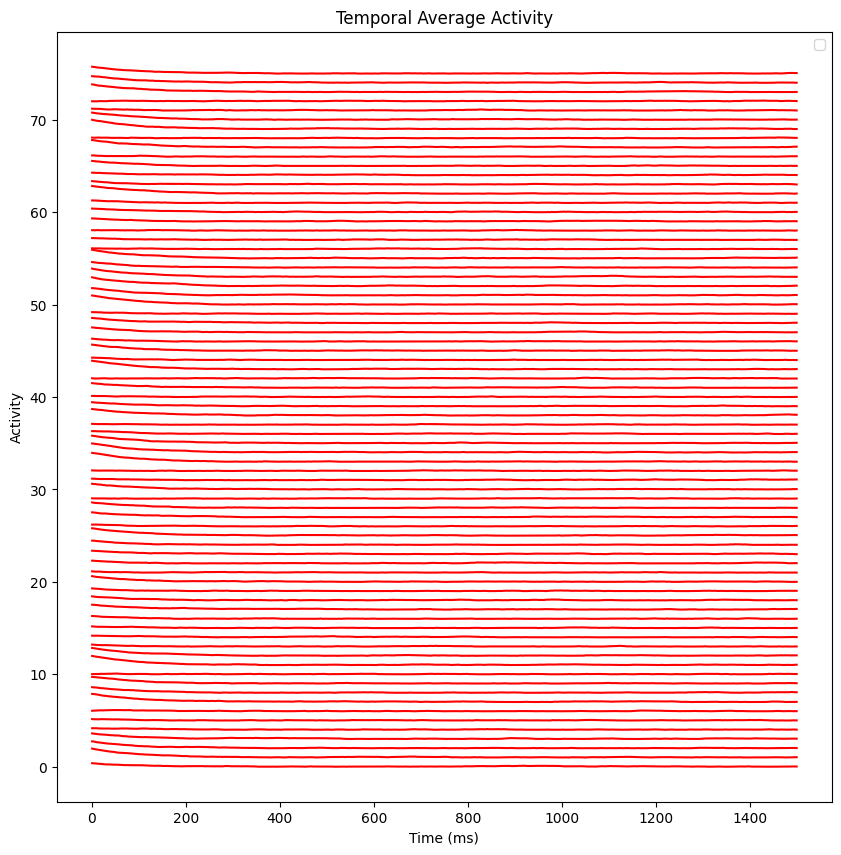

In [20]:
# Plot the TAA graph
plt.figure(figsize=(10, 10))
plt.plot(tavg_times_healthy[:], tavg_values_healthy[:, 0, :, 0] + np.r_[:76], 'r')

plt.xlabel("Time (ms)")
plt.ylabel("Activity")
plt.title("Temporal Average Activity")
plt.legend()
plt.show()

The TAA graph shows that the brain activity signals are highly stable and consistent through time. Only a small displacement in the beginning (when exposed to the stimulus) can be observed.

Let's take a look at the EEG signals.

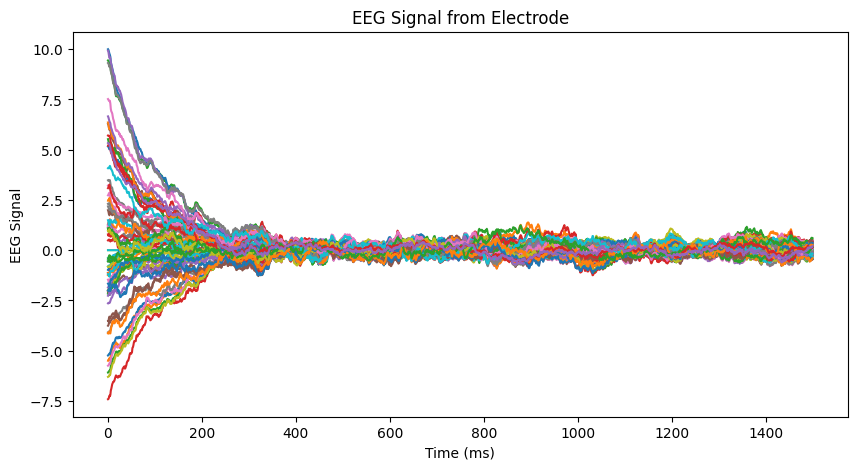

In [21]:
# Plot the EEG signal graph
plt.figure(figsize=(10, 5))
plt.plot(eeg_times_healthy[:], 10 * eeg_values_healthy[:, 0, :, 0])
plt.xlabel("Time (ms)")
plt.ylabel("EEG Signal")
plt.title("EEG Signal from Electrode")
plt.show()

The EEG graph shows that the brain, before the exposure to the stimulus, was in a resting state, its signals are more variable as the brain is not engaged. After 250ms, we see the signals converging to a tighter trajectory, indicating brain engagement. Early sensory processing lasts up to 100ms, and attention selection and categorization prolongs the time to roughly 200-300ms. 

This is what we expect during stimulus processing of a healthy individual. Let's check the correlation matrix. 

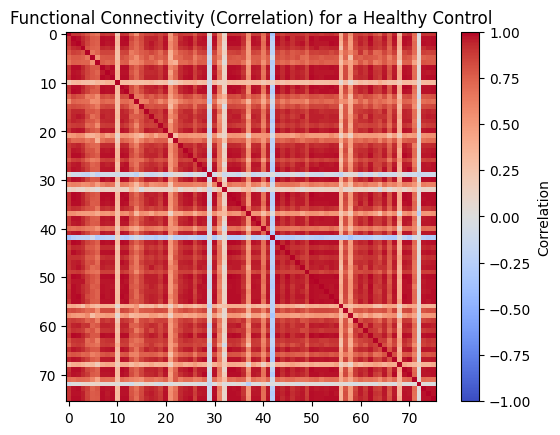

In [22]:
correlation_matrix_healthy = np.corrcoef(tavg_values_healthy[:, 0, :, 0].T)
plt.imshow(correlation_matrix_healthy, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title("Functional Connectivity (Correlation) for a Healthy Control")
plt.show()

The correlation matrix shows positive functional connectivity between regions. The brain is engaged towards the processing of the feature.

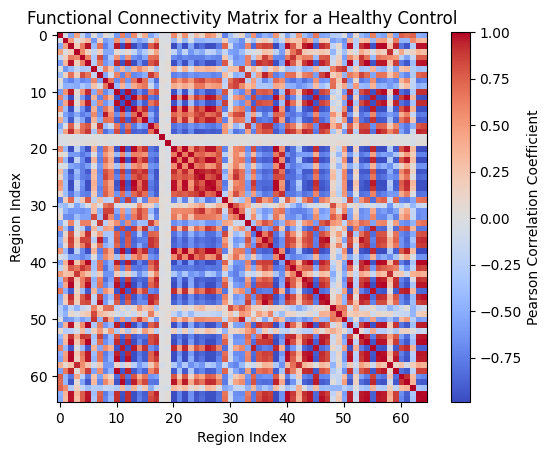

In [38]:
fc_matrix_healthy = np.corrcoef(eeg_values_healthy[:, 0, :, 0].T)

plt.imshow(fc_matrix_healthy, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Pearson Correlation Coefficient")
plt.title("Functional Connectivity Matrix for a Healthy Control")
plt.xlabel("Region Index")
plt.ylabel("Region Index")
plt.show()

# The Schizophrenic patient
In a schizophrenic patient, at the level of the brain activity, may show hypoactivity of the prefrontal cortex, abnormal dopamine activity, altered glutamate and GABA functioning. Also, connectivity is distrupted in certain regions, strengthened in others in an altered way. Finally, it might display aberrant brain network dynamics, such as impaired synchronization in the frontal-parietal network. 

In [23]:
model_schizo = models.ReducedWongWang(
    I_o = np.ones((76)) * 0.25,
    w = np.array([0.4]),
    J_N = np.array([0.22]),
    sigma_noise = np.ones((76)) * 5e-9
)

# Increase I_ext for some DMN nodes
model_schizo.I_o[[7, 10, 20]] = np.ones((3)) * 1.5
# Decrease I_ext for some task-positive regions
model_schizo.I_o[[30, 40, 50]] = np.ones((3)) * 0.75
model_schizo.sigma_noise[[7, 10, 20]] = np.array([0.01]) 

conn_schizo = connectivity.Connectivity.from_file()
# Increase connectivity within DMN regions (e.g., regions 7, 10, 20)
conn_schizo.weights[7, 10] *= 1.5
conn_schizo.weights[10, 20] *= 1.5
conn_schizo.weights[7, 20] *= 1.5
# Decrease connectivity between DMN and task-positive regions
conn_schizo.weights[7, 30] *= 0.5
conn_schizo.weights[10, 40] *= 0.5
conn_schizo.weights[20, 50] *= 0.5

coupling_schizo = Linear() # global coupling

noise_schizo = Additive(nsig = np.ones((1, 76)) * 0.00001)

integrator_schizo = HeunStochastic(dt=0.1, noise = noise_healthy)

# load the default region mapping
rm = region_mapping.RegionMapping.from_file()

# Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_EEG = monitors.EEG.from_file()
mon_EEG.region_mapping = rm
mon_EEG.period = 1.0

# Bundle them
what_to_watch = (mon_tavg, mon_EEG)

2025-02-05 15:25:14,515 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


We start the simulation, same as before.

In [31]:
# Initialize simulator
sim = simulator.Simulator(
    model = model_schizo,
    connectivity = conn_schizo,
    coupling = coupling_schizo,
    integrator = integrator_schizo,
    monitors = what_to_watch)

# Configure and run simulation
sim.configure()

output_schizo = sim.run(simulation_length=1500)

2025-02-05 15:37:28,803 - INFO - tvb.simulator.history - history has n_time=513 n_cvar=1 n_node=76 n_nmode=1, requires 0.32 MB
2025-02-05 15:37:28,804 - INFO - tvb.simulator.history - sparse history has n_nnzw=1560, i.e. 27.01 % sparse


In [32]:
# Unpack monitor outputs
tavg_data_schizo, eeg_data_schizo = output_schizo

# Temporal Average monitor
tavg_times_schizo = tavg_data_schizo[0]  # Time points (in ms)
tavg_values_schizo = tavg_data_schizo[1]  # Region activity data

# EEG monitor
eeg_times_schizo = eeg_data_schizo[0]  # Time points (in ms)
eeg_values_schizo = eeg_data_schizo[1]  # EEG data

# Normalize time series
tavg_values_schizo /= np.max(tavg_values_schizo)
eeg_values_schizo /= np.max(eeg_values_schizo)

C:\Users\andre\AppData\Local\Temp\ipykernel_64584\4093000336.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


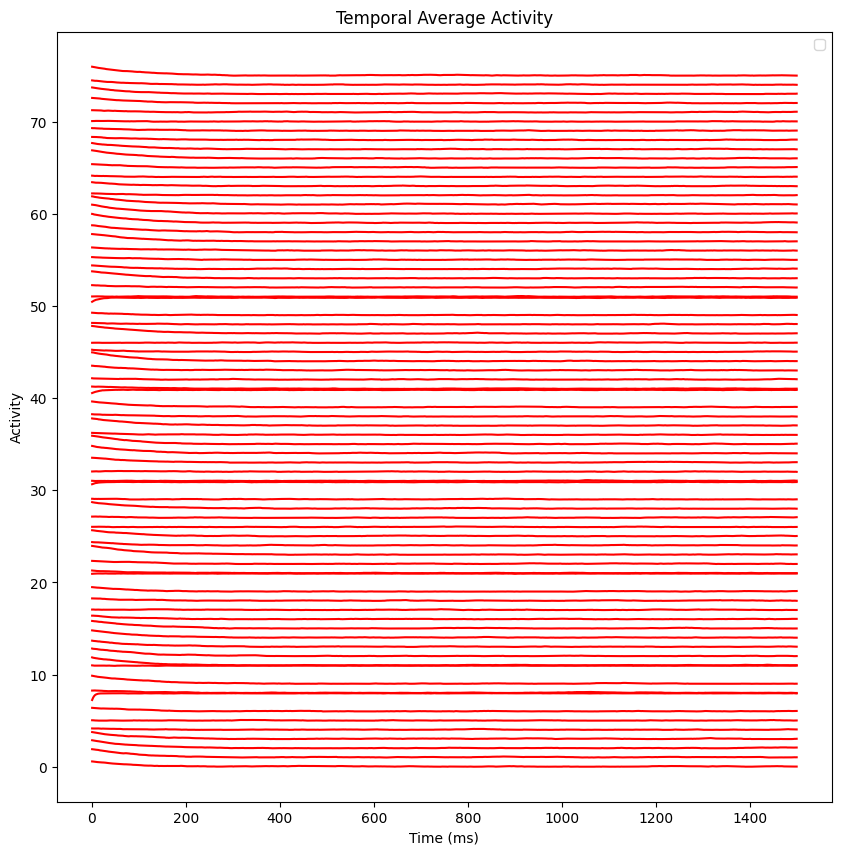

In [33]:
# Plot the TAA graph
plt.figure(figsize=(10, 10))
plt.plot(tavg_times_schizo[:], tavg_values_schizo[:, 0, :, 0] + np.r_[:76], 'r')

plt.xlabel("Time (ms)")
plt.ylabel("Activity")
plt.title("Temporal Average Activity")
plt.legend()
plt.show()

We don't see much variability... Let's see what is going on in the EEG signal graph.

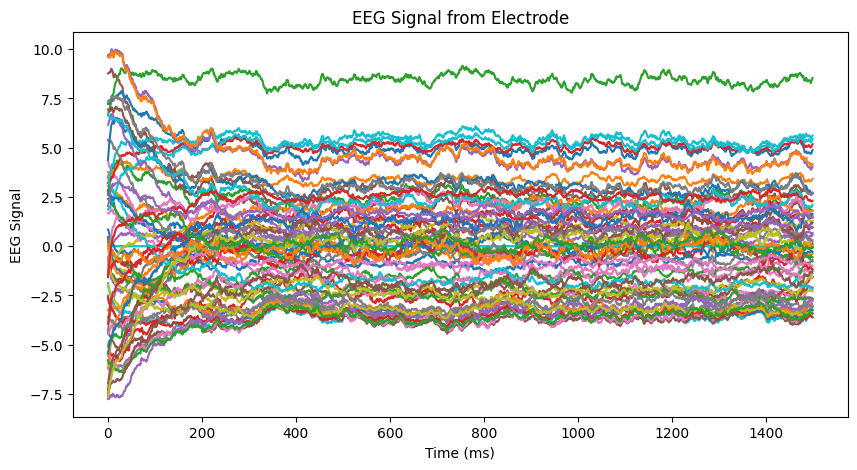

In [34]:
# Plot the EEG signal graph
plt.figure(figsize=(10, 5))
plt.plot(eeg_times_schizo[:], 10 * eeg_values_schizo[:, 0, :, 0])
plt.xlabel("Time (ms)")
plt.ylabel("EEG Signal")
plt.title("EEG Signal from Electrode")
plt.show()

While the TAA graph shows little variability, the EEG graph shows a lack of convergence of the signals. This is a clear sign of lack of synchronization, and thus difficulties in the ability of the brain to communicate within its regions. Let's take a look at the correlation matrix:

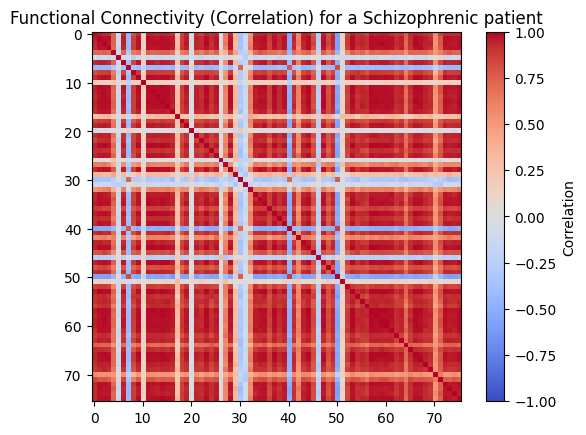

In [36]:
correlation_matrix = np.corrcoef(tavg_values_schizo[:, 0, :, 0].T)
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title("Functional Connectivity (Correlation) for a Schizophrenic patient")
plt.show()

On the regions where we modified there is a lack of functional connectivity, and possibly negative correlation.

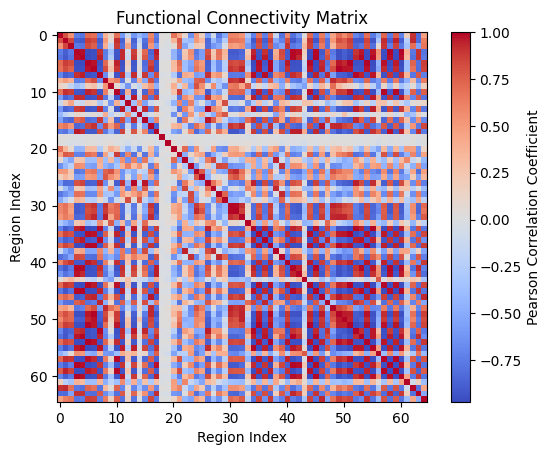

In [40]:
# Compute pairwise Pearson correlations
fc_matrix = np.corrcoef(eeg_values_schizo[:, 0, :, 0].T)  # Correlation across time points for all regions

# Plot the functional connectivity matrix
plt.imshow(fc_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Pearson Correlation Coefficient")
plt.title("Functional Connectivity Matrix")
plt.xlabel("Region Index")
plt.ylabel("Region Index")
plt.show()


# Phase Plane Analysis
We do Phase Plane Analysis to explore how changing some of the key parameters of the Wong-Wang model affects the phase plane.

In [42]:
from ipywidgets import interact, FloatSlider

# Sigmoid activation function for neuronal response
def H(x):
    return 1 / (1 + np.exp(-x))

# Define the Wong-Wang system
def wong_wang(S, x, J_N, w, I_o, gamma=0.641, tau_s=100.0):
    """
    Reduced Wong-Wang model dynamics for phase plane analysis.
    """
    dS_dt = -S / tau_s + (1 - S) * gamma * H(J_N * S + w + I_o)
    dx_dt = -x + J_N * S + w + I_o  # Auxiliary variable
    return dS_dt, dx_dt

# Function to plot phase plane
def plot_phase_plane(J_N, w, I_o, gamma, tau_s):
    """
    Plot the phase plane with given parameters.
    """
    # Create a grid of S and x values
    S = np.linspace(0, 1, 100)  # S ranges between 0 and 1
    x = np.linspace(-0.5, 1.0, 100)  # Auxiliary variable range
    S_grid, x_grid = np.meshgrid(S, x)

    # Compute vector field
    dS, dx = wong_wang(S_grid, x_grid, J_N, w, I_o, gamma, tau_s)

    # Normalize the vectors for visualization
    norm = np.sqrt(dS**2 + dx**2) + 1e-6  # Prevent division by zero
    dS /= norm
    dx /= norm

    # Plot the phase plane
    plt.figure(figsize=(10, 7))
    plt.quiver(S_grid, x_grid, dS, dx, color="blue", alpha=0.3, scale=30, label="Vector Field")
    plt.title(f"Phase Plane (J_N={J_N:.2f}, w={w:.2f}, I_o={I_o:.2f})", fontsize=14)
    plt.xlabel("S (Synaptic Gating Variable)", fontsize=12)
    plt.ylabel("x (Auxiliary Variable)", fontsize=12)
    plt.grid()

    # Compute and plot nullclines using 1D arrays to avoid multiple legend entries
    # dx/dt = 0 nullcline: x = J_N * S + w + I_o
    S_values = np.linspace(0, 1, 300)
    x_nullcline = J_N * S_values + w + I_o
    plt.plot(S_values, x_nullcline, color="green", linestyle="--", label="Nullcline (dx/dt = 0)")
    
    # dS/dt = 0 nullcline: S = (gamma * tau_s * H(x)) / (1 + gamma * tau_s * H(x))
    x_values = np.linspace(-0.5, 1.0, 300)
    H_x = H(x_values)
    S_nullcline = (gamma * tau_s * H_x) / (1 + gamma * tau_s * H_x)
    plt.plot(S_nullcline, x_values, color="red", linestyle="--", label="Nullcline (dS/dt = 0)")

    plt.legend(fontsize=10, loc='upper right')
    plt.show()

# Create interactive sliders
interact(
    plot_phase_plane,
    J_N=FloatSlider(value=0.2609, min=0.1, max=0.5, step=0.01, description="J_N"),
    w=FloatSlider(value=0.6, min=0.1, max=1.0, step=0.01, description="w"),
    I_o=FloatSlider(value=0.33, min=-1.0, max=1.0, step=0.1, description="I_ext"),
    gamma=FloatSlider(value=0.641, min=0.1, max=1.0, step=0.01, description="gamma"),
    tau_s=FloatSlider(value=100., min=50, max=500, step=25, description="tau_s")
)

interactive(children=(FloatSlider(value=0.2609, description='J_N', max=0.5, min=0.1, step=0.01), FloatSlider(v…

<function __main__.plot_phase_plane(J_N, w, I_o, gamma, tau_s)>

We have seen how changing such parameters affect the trajectory and the critical point of the nullcline.